In [ ]:
# default_exp face_class_ver

In [ ]:
import os
os.chdir('..')
os.getcwd()

In [3]:
#hide
%load_ext autoreload
%autoreload 2

In [4]:
#export
# imports
import os
import time
from functools import partial
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_auc_score

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

from hw2p2.models.resnet import *
from hw2p2.hyperoptimization import fit_predict
#from hw2p2.datasets import FaceClassificationDataset, FaceVerificationDataset

# DATASETS

In [5]:
#export
class FaceClassificationDataset(Dataset):
    """
    """
    def __init__(self,
                 mode,
                 trans_list):

        # Assertions to avoid wrong inputs
        assert mode in ['train', 'val', 'test']
        assert mode == 'test' and n_classes == None or mode != 'test'

        # Directory setup
        data_dirs = {'train': './nbs/data/s1/train_data',
                     'val': './nbs/data/s1/val_data',
                     'test': './nbs/data/s1/test_data'}
        self.data_dir = data_dirs[mode]
        self.mode = mode
        self.trans_list = trans_list

        # Labels
        if (mode in ['train', 'val']):
            #self.labels = np.array([int(d) for d in os.listdir(self.data_dir)])
            self.labels = np.array([int(d) for d in os.listdir(self.data_dir) \
                                           for file in os.listdir(f'{self.data_dir}/{d}')])
            
            self.X = np.array([str(file) for d in os.listdir(self.data_dir) \
                                           for file in os.listdir(f'{self.data_dir}/{d}')])
        
        elif mode == 'test':
            self.labels = os.listdir(self.data_dir)
            self.labels = np.array([int(f.split('.')[0]) for f in self.labels])
            self.labels.sort(axis=0)

            self.map_files = []
            for l in self.labels:
                temp_ls = [(l, f) for f in \
                    os.listdir(os.path.join(self.data_dir, str(l)))]
                temp_ls = [(t[0], t[1]) for t in temp_ls]
                self.map_files.append(temp_ls)

            self.map_files = [t for sl in self.map_files for t in sl]
            self.labels = [t[0] for t in self.map_files]
            self.X = [t[1] for t in self.map_files]
   
    def __len__(self): 
            return len(self.X)

    def __getitem__(self, idx):
        preprocess = transforms.Compose(self.trans_list)
        
        image_path = os.path.join(self.data_dir, 
                                  str(self.labels[idx]), 
                                  self.X[idx])
        image_tensor = Image.open(image_path)
        image_tensor = preprocess(image_tensor)

        if self.mode == 'test': 
            return image_tensor
        else: 
            return image_tensor, self.labels[idx]

In [6]:
#export
class FaceVerificationDataset(Dataset):
    """
    """
    def __init__(self,
                 sample=None,
                 mode='val'):

        # Assertions to avoid wrong inputs
        assert mode in ['val', 'test']
        assert mode == 'test' and sample == None or \
            mode != 'test'
        if sample is not None:
            assert isinstance(sample, (list, np.ndarray))

        self.mode = mode
        self.data_dir = './data/s2/'

        # Directory setup
        if mode == 'val': 
            self.pairs_file = \
                './data/s2/verification_pairs_val.txt'
        else:
            self.pairs_file = \
                './data/s2/verification_pairs_test.txt'

        with open(self.pairs_file) as f:
            self.pairs = [l.rstrip().split() for l in f]

        if sample is not None:
            sample = np.array(sample)
            sample.sort(axis=0)
            self.pairs = [self.pairs[i] for i in sample]            
   
    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        
        trans_list = [transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                               std=[0.229, 0.224, 0.225])]
        
        preprocess = transforms.Compose(trans_list)
        
        image_tensor_0 = Image.open(os.path.join(self.data_dir,self.pairs[idx][0]))
        image_tensor_1 = Image.open(os.path.join(self.data_dir,self.pairs[idx][1]))
        image_tensor_0 = preprocess(image_tensor_0)
        image_tensor_1 = preprocess(image_tensor_1)
        if self.mode == 'test': 
            return image_tensor_0, image_tensor_1
        else: 
            return image_tensor_0, image_tensor_1, int(self.pairs[idx][2])

## Visualization of original dataset

batch_x.shape torch.Size([4, 3, 80, 80])
batch_y.shape torch.Size([4])


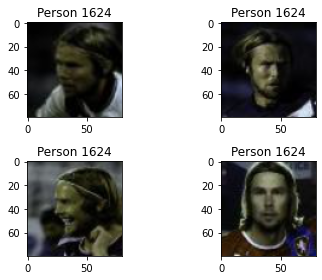

In [7]:
no_transf = [transforms.ToTensor(),
             transforms.Resize(80),
             #transforms.RandomCrop(64),
             #transforms.RandomHorizontalFlip(),
             #transforms.Normalize(mean=[0.485, 0.456, 0.406],
             #                     std=[0.229, 0.224, 0.225])
             ]
dataset = FaceClassificationDataset(trans_list=no_transf, mode='train')
dataloader = DataLoader(dataset, shuffle=False, batch_size=4, num_workers=0, drop_last=True)

batch_x, batch_y = next(iter(dataloader))
print("batch_x.shape", batch_x.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(batch_x[0,:,:,:].permute(1, 2, 0))
axs[0,0].set_title(f'Person {batch_y[0]}')

axs[0,1].imshow(batch_x[1,:,:,:].permute(1, 2, 0))
axs[0,1].set_title(f'Person {batch_y[1]}')

axs[1,0].imshow(batch_x[2,:,:,:].permute(1, 2, 0))
axs[1,0].set_title(f'Person {batch_y[2]}')

axs[1,1].imshow(batch_x[3,:,:,:].permute(1, 2, 0))
axs[1,1].set_title(f'Person {batch_y[3]}')
fig.tight_layout()
plt.savefig('./results/original_dataset.png')
plt.show()

### Visualization of training dataset

In [ ]:
normalize_transf = [transforms.Resize(80),
                    transforms.RandomCrop(64),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])]
dataset = FaceClassificationDataset(trans_list=normalize_transf, mode='train')
dataloader = DataLoader(dataset, shuffle=True, batch_size=4, num_workers=0, drop_last=True)

batch_x, batch_y = next(iter(dataloader))
print("batch_x.shape", batch_x.shape)
print("batch_y.shape", batch_y.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(batch_x[0,:,:,:].permute(1, 2, 0))
axs[0,0].set_title(f'Person {batch_y[0]}')

axs[0,1].imshow(batch_x[1,:,:,:].permute(1, 2, 0))
axs[0,1].set_title(f'Person {batch_y[1]}')

axs[1,0].imshow(batch_x[2,:,:,:].permute(1, 2, 0))
axs[1,0].set_title(f'Person {batch_y[2]}')

axs[1,1].imshow(batch_x[3,:,:,:].permute(1, 2, 0))
axs[1,1].set_title(f'Person {batch_y[3]}')
fig.tight_layout()
plt.savefig('./results/train_dataset.png')
plt.show()

# Distribution plot
pixels = batch_x[0,:,:,:].flatten().flatten()
sample = np.random.choice(range(len(pixels)), 1000)

fig, ax = plt.subplots(1, tight_layout=True)
ax.hist(pixels[sample])
plt.show()

In [ ]:
#export
def create_dataloaders(mc):
    num_workers = 8 if torch.cuda.is_available() else 0

    train_dataset = FaceClassificationDataset(n_labels=mc['n_classes'], mode='train')
    clf_dataset   = FaceClassificationDataset(n_labels=mc['n_classes'], mode='val')
    vrf_dataset   = FaceVerificationDataset(n_labels=mc['n_classes'], mode='val')

    print(f'n_train: {len(train_dataset)}, n_clf: {len(clf_dataset)}, n_vrf: {len(vrf_dataset)}')

    train_loader = DataLoader(train_dataset, 
                              shuffle=True, 
                              batch_size=mc['batch_size'], 
                              num_workers=num_workers, 
                              pin_memory=torch.cuda.is_available(),
                              drop_last=True)
    clf_loader = DataLoader(val_c_dataset, 
                            shuffle=False, 
                            batch_size=mc['batch_size'], 
                            num_workers=num_workers, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    vrf_loader = DataLoader(val_v_dataset, 
                            shuffle=False, 
                            batch_size=mc['batch_size'], 
                            num_workers=num_workers, 
                            pin_memory=torch.cuda.is_available(),
                            drop_last=True)
    
    assert len(train_loader) > 0
    assert len(val_c_loader) > 0
    assert len(val_v_loader) > 0
    
    return train_loader, clf_loader, vrf_loader

# HYPERPARAMETER OPTIMIZATION

In [5]:
#export
def main(model, sample_size=4000, max_evals=20):
    # Hyperparameters space
    space = {'model': hp.choice(label='model', options=[model]),
             'in_channels': hp.choice(label='in_channels', options=[3]),
             'n_classes': hp.choice(label='n_classes', options=[4000]),
             'batch_size': scope.int(hp.choice(label='batch_size', options=[2048])),
             'lr': hp.loguniform(label='lr', low=np.log(5e-3), high=np.log(5e-2)),
             'lr_decay': hp.choice(label='lr_decay', options=[0.5]),
             'n_lr_decay_steps': hp.choice(label='n_lr_decay_steps', options=[3]),
             'center_loss': hp.choice(label='center_loss', options=[True]),
             'lr_cl': hp.loguniform(label='lr_cl', low=np.log(5e-3), high=np.log(2e-1)),
             'alpha_cl': hp.choice(label='alpha_cl', options=[0.01, 0.1, 1]),
             'n_epochs': hp.choice(label='n_epochs', options=[1000]),
             'eval_epochs': scope.int(hp.choice(label='eval_epochs', options=[4])),
             'random_seed': scope.int(hp.quniform('random_seed', 1, 10, 1)),
             }

    train_loader, clf_loader, vrf_loader = create_dataloaders(mc)

    # Hyperparameters search
    trials = Trials()
    fmin_objective = partial(fit_predict, trials=trials, verbose=True, sample_size=sample_size)
    best = fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    
    keys = ['loss','val_c_loss','train_c_acc','val_c_acc','val_v_acc','run_time','trajectories']
    
    best_class = trials.results[np.argmax([r['val_c_acc'] for r in trials.results])]  
    best_class_res_dict = {key: best_class[key] for key in keys}
    best_class_model = best_class['model']
    best_class_mc = best_class['mc']
    best_class_time_stamp = best_class['time_stamp']
    
    s = 'hw2p2' + '_' + best_class_time_stamp
    filename = f'./results/{s}.pth'
    
    json_mc = json.dumps(best_class_mc)
    with open(f'./results/mc_{best_class_time_stamp}.json', 'w') as bfm: 
        bfm.write(json_mc)  
    json_res = json.dumps(best_class_res_dict)
    with open(f'./results/res_dict_{best_class_time_stamp}.json', 'w') as bfm: 
        bfm.write(json_res)  
        
    torch.save(best_class_model.model.state_dict(), filename)

    best_ver = trials.results[np.argmax([r['val_v_acc'] for r in trials.results])]
    best_ver_res_dict = {key: best_ver[key] for key in keys}
    best_ver_model = best_ver['model']
    best_ver_mc = best_ver['mc']
    best_ver_time_stamp = best_ver['time_stamp']
    
    s = 'hw2p2' + '_' + best_ver_time_stamp
    filename = f'./results/{s}.pth'
    
    json_mc = json.dumps(best_ver_mc)
    with open(f'./results/mc_{best_ver_time_stamp}.json', 'w') as bfm: 
        bfm.write(json_mc) 
    json_res = json.dumps(best_ver_res_dict)
    with open(f'./results/res_dict_{best_ver_time_stamp}.json', 'w') as bfm: 
        bfm.write(json_res)  
        
    torch.save(best_ver_model.model.state_dict(), filename)


In [6]:
os.getcwd()
# os.chdir('..')

'/home/ubuntu/hw2p2'

In [7]:
#export
if __name__ == "__main__":
    main(model='resnet18', sample_size=3000, max_evals=20)

                                                      
Current directory: /home/ubuntu/hw2p2

18-03-21_16-54-06                                     
alpha_cl                   1                          
batch_size              2048
center_loss             True
eval_steps                 4
in_channels                3
lr                  0.005307
lr_cl               0.016201
lr_decay                 0.5
model               resnet18
n_classes               3000
n_epochs                1000
n_lr_decay_steps           3
dtype: object

train_dataset_len: 285327, val_c_dataset_len: 6000, val_v_dataset_len: 3000
==============================Start Fitting==============================
epoch: 0 train_loss: 529.4289 train_c_acc: 0.04% val_c_loss: 522.5351 val_c_acc: 0.02% val_v_acc: 63.70% 
epoch: 4 train_loss: 511.6295 train_c_acc: 0.04% val_c_loss: 520.4347 val_c_acc: 0.07% val_v_acc: 73.71% 
epoch: 8 train_loss: 504.5949 train_c_acc: 0.04% val_c_loss: 520.979 val_c_acc: 0.02% val_v_acc: 73.

KeyboardInterrupt: 

In [8]:
os.getcwd()

'/home/ubuntu/hw2p2'

In [ ]:
import json

model_mc_file = './results/mc_17-03-21_23-28-42.json'
with open(model_mc_file) as f: mc = json.load(f)
model_mc_file = './results/res_dict_17-03-21_23-28-42.json'
with open(model_mc_file) as f: res = json.load(f)
model_file = './results/hw2p2_17-03-21_23-28-42.pth'

model = ResNetN(18,
                in_channels=mc['in_channels'],
                n_classes=mc['n_classes'],
                lr=mc['lr'],
                lr_decay=mc['lr_decay'],
                n_lr_decay_steps=mc['n_lr_decay_steps'],
                center_loss = mc['center_loss'],
                lr_cl=mc['lr_cl'],
                alpha_cl=mc['alpha_cl'],
                n_epochs=mc['n_epochs'],
                eval_steps=mc['eval_steps'])

model.model.load_state_dict(torch.load(model_file))

In [ ]:
print(res)
print(mc)

In [ ]:
model_mc_file = './results/mc_17-03-21_23-28-57.json'
with open(model_mc_file) as f: mc = json.load(f)
model_mc_file = './results/res_dict_17-03-21_23-28-57.json'
with open(model_mc_file) as f: res = json.load(f)
model_file = './results/hw2p2_17-03-21_23-28-57.pth'

model = ResNetN(18,
                in_channels=mc['in_channels'],
                n_classes=mc['n_classes'],
                lr=mc['lr'],
                lr_decay=mc['lr_decay'],
                n_lr_decay_steps=mc['n_lr_decay_steps'],
                center_loss = mc['center_loss'],
                lr_cl=mc['lr_cl'],
                alpha_cl=mc['alpha_cl'],
                n_epochs=mc['n_epochs'],
                eval_steps=mc['eval_steps'])

model.model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [ ]:
print(res)
print(mc)

{'loss': -1.0, 'val_c_loss': -1, 'train_c_acc': 0.10276442307692307, 'val_c_acc': 0.125, 'val_v_acc': 0.47619047619047616, 'run_time': 14.389012336730957, 'trajectories': {'epoch': [0, 4], 'train_loss': [7.035186199041513, 5.624412055198963], 'train_c_acc': [0.09254807692307693, 0.10276442307692307], 'val_c_loss': [12.188202381134033, 12.305235862731934], 'val_c_acc': [0.125, 0.125], 'val_v_acc': [0.47619047619047616, 0.47619047619047616]}}
{'alpha_cl': 0.01, 'batch_size': 16, 'center_loss': True, 'eval_steps': 4, 'in_channels': 3, 'lr': 0.029865896744795523, 'lr_cl': 0.15374739504606688, 'lr_decay': 0.5, 'model': 'resnet18', 'n_classes': 20, 'n_epochs': 5, 'n_lr_decay_steps': 3}


In [8]:
arr = np.arange(10)
np.random.shuffle(arr)
arr

array([2, 4, 3, 1, 9, 5, 8, 0, 7, 6])